**Table of contents**<a id='toc0_'></a>    
- [Mise en place](#toc1_)    
  - [Chargement des données](#toc1_1_)    
  - [Préparation des données](#toc1_2_)    
- [Approches Bag-of-words](#toc2_)    
  - [Méthode de scoring](#toc2_1_)    
  - [TF-IDF](#toc2_2_)    
- [CountVectorizer](#toc3_)    
- [LDA](#toc4_)    
- [🦄🦄 CHECKPOINT 🦄🦄](#toc5_)    
- [🚧 gensim LDA ?](#toc6_)    
- [🚧 calcul matriciel pour predictions avec LDA](#toc7_)    
- [🚧 NMF](#toc8_)    
- [🚧 vrac utile](#toc9_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=2
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Mise en place](#toc0_)

In [1]:
# OS & env
import os
import logging
import time

# DS
import numpy as np
import pandas as pd
import dill as pickle

# ML
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from Levenshtein import ratio

# home made functions from the src folder
from src.scrap_and_clean import words_filter
from src.models import results_from_vec_matrix
from src.models import get_5_tags_from_matrix
from src.models import score_reduce
from src.models import plot_model
from src.models import vect_data
from src.models import get_lda_topics
from src.models import lda_weights_df
from src.models import lda_predict

# logging configuration (see all outputs, even DEBUG or INFO)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

## <a id='toc1_1_'></a>[Chargement des données](#toc0_)

### 🚧 Si pas de données pré-traitées, faire pré-traitement au lieu de message "run EDA NB"

In [2]:
if not os.path.exists("data/data_preprocessed.pkl"):
    logging.warning("Missing data: run EDA notebook first")
else:
    with open("data/data_preprocessed.pkl", "rb") as df:
        df = pickle.load(df)

In [3]:
print(f"DF shape: {df.shape}")
display(df.head())

DF shape: (50000, 10)


,Title,Body,Tags,Score,AnswerCount,CreationDate,ViewCount,title_bow,body_bow,doc_bow
0,ITMS-91053: Missing API declaration - Privacy,<p>Why am I all of a suddent getting this on s...,"[ios, app-store, plist, appstore-approval, pri...",24,7,2024-03-14 22:55:18,3092,itms-91053 missing api declaration privacy,suddent getting successful builds apple,itms-91053 missing api declaration privacy sud...
1,Why is builtin sorted() slower for a list cont...,<p>I sorted four similar lists. List <code>d</...,"[python, algorithm, performance, sorting, time...",28,2,2024-03-05 15:21:50,2699,builtin sorted slower list containing descendi...,sorted four similar lists list consistently ta...,builtin sorted slower list containing descendi...
2,std::shared_mutex::unlock_shared() blocks even...,<p>My team has encountered a deadlock that I s...,"[c++, windows, multithreading, stl, shared-lock]",26,5,2024-03-01 23:09:59,1388,std :shared_mutex :unlock_shared blocks even t...,team encountered deadlock suspect bug windows ...,std :shared_mutex :unlock_shared blocks even t...
3,Did the rules for nullptr init of unique_ptr c...,<p>This code compiles with MSVC from VS 2022 i...,"[c++, visual-c++, language-lawyer, unique-ptr,...",15,1,2024-02-22 11:29:42,490,rules nullptr init unique_ptr change c++,compiles msvc c++ mode failes c++ mode current...,rules nullptr init unique_ptr change c++ compi...
4,Where is the order in which ELF relocations ar...,<p>Consider the following two files on a Linux...,"[c++, elf, dynamic-linking, abi, relocation]",16,1,2024-02-19 21:42:03,1746,order elf relocations applied specified,consider following two linux system use_messag...,order elf relocations applied specified consid...


## <a id='toc1_2_'></a>[Préparation des données](#toc0_)

Données communes

In [4]:
tags = df["Tags"].apply(lambda x: " ".join(x)).to_list()
titles = df["title_bow"].to_list()
bodies = df["body_bow"].to_list()
corpus = df["doc_bow"].to_list()

Séparation de 1000 documents pour les tests, le reste pour l'entraînement des modèles

In [5]:
random_state = 42

# isolate target
X_df = df.loc[:, df.columns != "Tags"]

# split entire DF for further use
X_train_df, X_test_df, y_train, y_test = train_test_split(
    X_df, tags, test_size=1000, random_state=random_state
)

# then set genuine features for models
X_train = X_train_df["doc_bow"].to_list()
X_test = X_test_df["doc_bow"].to_list()

# <a id='toc2_'></a>[Approches Bag-of-words](#toc0_)

## 🚧 Expliquer ce que c'est

## <a id='toc2_1_'></a>[Méthode de scoring](#toc0_)

On cherche à évaluer l'efficacité d'un modèle qui renvoie deux listes de termes, sans toutefois appliquer de solution binaire comme la présence ou non du terme exact dans les deux listes, au vu de la diversité des termes employés.

Un moyen simple d'utiliser le meilleur ratio de Levenshtein (similarité entre chaînes de caractères) avec un seuil cohérent et de le diviser par le nombre de termes.

> Une similarité de 70% permet par exemple de mettre une similarité de 0 entre 'c' et 'c#', une similarité de 0.71 entre 'spring' et 'spring-boot' mais de 0 entre 'spring-boot' et 'boot'.



- le score maximum de 1 équivaut à tous les termes exacts trouvés,
- le minimum de 0 signifie qu'il n'y a pas eu de terme suffisamment proche pour passer le seuil défini

In [6]:
def score_terms(pred_words, target_words, cutoff=0.7) -> float:
    """Return a score of terms similarity between 2 lists of strings"""
    score = 0
    for p_w in pred_words:
        score += max(ratio(t, p_w, score_cutoff=cutoff) for t in target_words)
    score = np.round(score / len(pred_words), 3)
    
    return score

# <a id='toc2_2_'></a>[TF-IDF](#toc0_)

[Documentation ScikitLearn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

Un modèle simple de prédictions se basant sur les fréquences de monogrammes présents dans un corpus.

#### 🚧 Expliquer modèle

Entraînement du modèle sur l'échantillon d'entraînement

In [7]:
tfidf_vectorizer = TfidfVectorizer(token_pattern=r"\S+", min_df=10)
tfidf_fitted = tfidf_vectorizer.fit(X_train)
tfidf_names = tfidf_vectorizer.get_feature_names_out()

Exemple sur un document du test

In [8]:
# create a random example in test set
example_doc_index = 42
doc = X_test[example_doc_index]
origin_doc = X_test_df.iloc[example_doc_index]

# get the target
y = y_test[example_doc_index].split(" ")

# predict
X = tfidf_fitted.transform(X_test)
doc_transformed = X[example_doc_index]

# display predictions
predictions = results_from_vec_matrix(tfidf_names, doc_transformed)
pred_words = [p[0] for p in predictions]

print(f"🔹 Original document:\n\t{origin_doc[['Title', 'Body']].values}\n")
print(f"🔹 Preprocessed data:\n\t{doc}\n")
print(f"🔹 Predictions:\n\t{pred_words}\n")
print(f"🔹 Targetted tags:\n\t{y}\n")
print(f"🔹 Score:\n\t{score_terms(pred_words, y)}\n")

🔹 Original document:
	['Motion/Moving effect with animation on still image'
 '<p>I am trying to implement animation in a still image in a user-guided direction, something like this:</p>\n\n<p><strong>Original image</strong></p>\n\n<p><a href="https://i.stack.imgur.com/U0JTq.png" rel="noreferrer"><img src="https://i.stack.imgur.com/U0JTq.png" alt="original image"></a></p>\n\n<p><strong>Expected result</strong></p>\n\n<p><a href="https://i.stack.imgur.com/BSgEC.gif" rel="noreferrer"><img src="https://i.stack.imgur.com/BSgEC.gif" alt="expected result"></a></p>\n\n<p>For this, I have tried the <code>CIBumpDistortionLinear</code> <code>CIFilter</code>. It is animating, but the animation is not exactly like that. </p>\n\n<pre><code>let bumpDistortionLinearParams: [String: AnyObject] = [\n    kCIInputImageKey: coreImage!,\n    "inputCenter" : CIVector(string: coordStr),\n    "inputRadius": 300.0 as AnyObject,\n    "inputAngle" : 90.0 as AnyObject,\n    "inputScale" : 0.1 as AnyObject\n]\n\nle

Application sur nos données de test

In [9]:
results = score_reduce(tfidf_names, tfidf_fitted.transform(X_test), y_test)

# check with sample
print("Check with example sample")
print(results[1][example_doc_index])
print(results[2][example_doc_index])

Score:  0.232 - Duration:  13.0
Check with example sample
['animation', 'image', 'animating', 'still', 'direction']
0.157


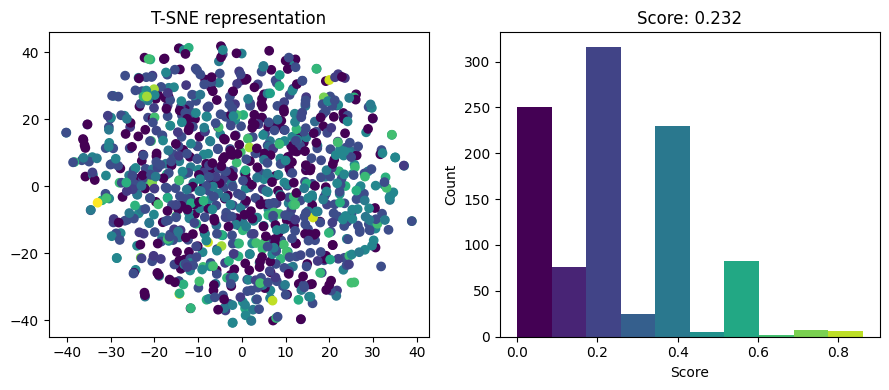

In [10]:
plot_model(results[0], results[2], results[3])

De par son fonctionnement, **TF-IDF ne propose pas les tags les plus fréquents**, tels que les noms de langages informatiques ou bibliothèques régulièrement utilisées : c'est là une des limites de cette approche simple.

# <a id='toc3_'></a>[CountVectorizer](#toc0_)

[Documentation ScikitLearn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

#### 🚧 Expliquer modèle

Modèle de comptage vectoriel

In [11]:
count_vectorizer = CountVectorizer(token_pattern=r"\S+", dtype=np.uint16, min_df=10)

Entraînement

In [12]:
cv_fitted = count_vectorizer.fit(X_train)
cv_names = count_vectorizer.get_feature_names_out()

Résultats sur l'échantillon de test

Score:  0.197 - Duration:  15.0


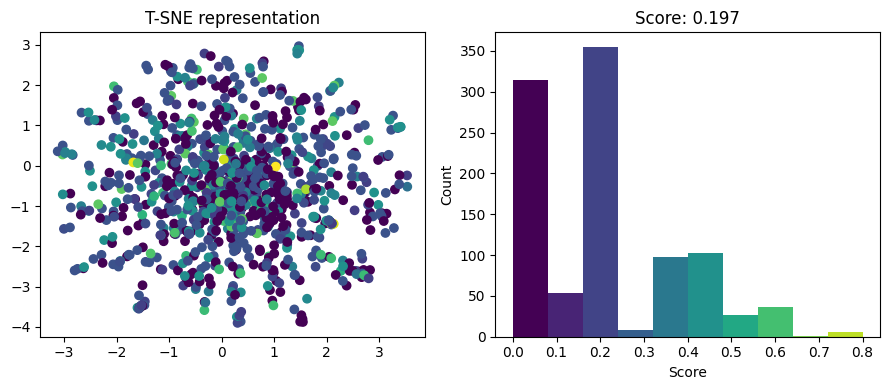

In [13]:
results = score_reduce(cv_names, cv_fitted.transform(X_test), y_test)
plot_model(results[0], results[2], results[3])

# <a id='toc4_'></a>[LDA](#toc0_)

[Documentation ScikitLearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html)

[pyLDAvis for visualization](https://medium.com/@sherryqixuan/topic-modeling-and-pyldavis-visualization-86a543e21f58)

[LDA Gensim 1](https://radimrehurek.com/gensim/wiki.html#latent-dirichlet-allocation)
[LDA Gensim 2](https://radimrehurek.com/gensim/models/ldamodel.html#gensim.models.ldamodel.LdaModel)

[❤️ LDA in TDS](https://towardsdatascience.com/topic-modeling-quora-questions-with-lda-nmf-aff8dce5e1dd)

#### 🚧 Expliquer modèle

Modèle LDA avec 20 topics

In [14]:
# define a maximum number of topics (each represented by some words)
n_topics = 20

# LDA model
lda = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)

LDA prend une matrice de vecteurs en entrée : utilisation de CountVectorizer

In [15]:
cv = CountVectorizer(token_pattern=r"\S+", dtype=np.uint16, min_df=10)
cv_data = cv.fit_transform(X_train)
cv_names = cv.get_feature_names_out()

Entraînement

In [16]:
lda.fit(cv_data)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=20, random_state=0)

Affichage des topics

In [17]:
n_top_words = 10
topics = get_lda_topics(lda, cv_names, n_top_words)
topics

['image element images input size text color output get example',
 'studio core .net project visual framework asp.net application web c#',
 'test server request get tests http response client api service',
 'python column dataframe convert format pandas date variables data columns',
 'list array value string java form elements values get map',
 'function type c++ class example following question method functions way',
 "'ve work way one also know solution problem question something",
 'project build tried get module command following app install trying',
 'version update line problem following running windows warning output fine',
 'number key two one table value different first values r',
 'page component react docker chrome angular container browser html app',
 'node dependencies django github git tutorial repo deploy repository dependency',
 'json model azure nested tensorflow matrix pipeline graph dictionary python',
 'text bootstrap safari height characters cell character keyboard

Application aux données de test

In [18]:
# predict
X_cv = cv.transform(X_test)
X_lda = lda.transform(X_cv)

Essai sur un exemple

In [19]:
n_top_topics = 5   # best topics for each input

# create a random example in test set
example_doc_index = 42
doc = X_test[example_doc_index]
origin_doc = X_test_df.iloc[example_doc_index]

# get the n top topics
top_topics = X_lda[example_doc_index].argsort()[: -n_top_topics - 1 : -1]
# get its weights
top_topics_weights = X_lda[example_doc_index][top_topics]

print(f"🔹 Original document:\n\t{origin_doc[['Title', 'Body']].values}\n")
print(f"🔹 Preprocessed data:\n\t{doc}\n")
# predict topics
print(f"🔹 Top {n_top_topics} topics:")
for topic in top_topics:
    print(f"\tTopic {topic} (weight {X_lda[example_doc_index][topic]}):\n\t\t{topics[topic]}")

🔹 Original document:
	['Motion/Moving effect with animation on still image'
 '<p>I am trying to implement animation in a still image in a user-guided direction, something like this:</p>\n\n<p><strong>Original image</strong></p>\n\n<p><a href="https://i.stack.imgur.com/U0JTq.png" rel="noreferrer"><img src="https://i.stack.imgur.com/U0JTq.png" alt="original image"></a></p>\n\n<p><strong>Expected result</strong></p>\n\n<p><a href="https://i.stack.imgur.com/BSgEC.gif" rel="noreferrer"><img src="https://i.stack.imgur.com/BSgEC.gif" alt="expected result"></a></p>\n\n<p>For this, I have tried the <code>CIBumpDistortionLinear</code> <code>CIFilter</code>. It is animating, but the animation is not exactly like that. </p>\n\n<pre><code>let bumpDistortionLinearParams: [String: AnyObject] = [\n    kCIInputImageKey: coreImage!,\n    "inputCenter" : CIVector(string: coordStr),\n    "inputRadius": 300.0 as AnyObject,\n    "inputAngle" : 90.0 as AnyObject,\n    "inputScale" : 0.1 as AnyObject\n]\n\nle

La visualisation des topics est efficace mais on souhaite la prédiction de 5 tags à partir des topics.

## Topic → prédiction de mots

Pour cela, il est possible de pondérer le poids de chacun des 10 meilleurs mots d'un topic par la probabilité du topic lui-même, puis de récupérer les 5 meilleurs mots qui en ressortent.

Pour chaque topic, sauvegarde des 10 meilleurs poids et mots associés dans un dataframe :

In [20]:
lda_df = lda_weights_df(lda, cv_names)
lda_df.head()

,topic,index,word,weight
0,0,4268,image,5242.852403
1,0,2918,element,2356.320153
2,0,4271,images,2018.040203
3,0,4482,input,2013.835591
4,0,8166,size,1780.449876


Prédictions pour l'échantillon de test

In [21]:
X_results = [lda_predict(lda_df, xi) for xi in X_lda]

Sur le document d'exemple

In [22]:
pred_words = X_results[example_doc_index][1]
y = y_test[example_doc_index]

print(f"\n🔹 Words prediction:\n\t{pred_words}\n")
print(f"🔹 Targetted tags:\n\t{y}\n")
print(f"🔹 Score:\n\t{score_terms(pred_words, y)}\n")


🔹 Words prediction:
	["'ve", 'image', 'work', 'way', 'one']

🔹 Targetted tags:
	ios swift core-animation core-image glkit

🔹 Score:
	0.0



Résultats sur l'échantillon de test

Score:  0.047 - Duration:  16.0


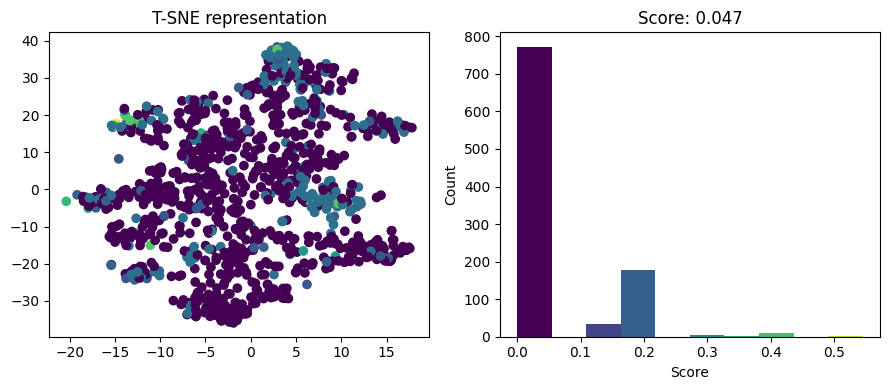

In [25]:
results = score_reduce(cv_names, X_lda, y_test, model_type="lda", model=lda)
plot_model(results[0], results[2], results[3])

# <a id='toc5_'></a>[🦄🦄 CHECKPOINT 🦄🦄](#toc0_)

# <a id='toc8_'></a>[🚧 NMF](#toc0_)

# <a id='toc9_'></a>[🚧 vrac utile](#toc0_)

Création d'un titre fictif pour tests ultérieurs

In [ ]:
dummy_doc = "i have a c# issue with overflow memory in library kazakhstanislas causing many problems in my code: how do you manage this? Here is an example: <code>int a = 1; int b = 2; int c = a + b;</code>"

In [ ]:
# stats_df.loc[stats_df.count_title > 10].sort_values(by="count_title", ascending=False)